Part 1

In [ ]:
import torch
from torch import nn
from torch.nn import functional as F
from torchvision import datasets, transforms
from skimage.metrics import structural_similarity as ssim


In [ ]:
# Define hyperparameters
input_size = 784  # MNIST images are 28x28 pixels
latent_size = 128  # Size of latent representation
batch_size = 64
epochs = 10
learning_rate = 1e-3


In [ ]:
# Load MNIST dataset
train_dataset = datasets.MNIST('./data', train=True, download=True, transform=transforms.ToTensor())
train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size, shuffle=True)

test_dataset = datasets.MNIST('./data', train=False, download=True, transform=transforms.ToTensor())
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=batch_size, shuffle=False)


100%|██████████| 9912422/9912422 [00:00<00:00, 115305839.50it/s]


Extracting ./data/MNIST/raw/train-images-idx3-ubyte.gz to ./data/MNIST/raw



100%|██████████| 28881/28881 [00:00<00:00, 53885984.80it/s]


Extracting ./data/MNIST/raw/train-labels-idx1-ubyte.gz to ./data/MNIST/raw



100%|██████████| 1648877/1648877 [00:00<00:00, 26555561.34it/s]


Extracting ./data/MNIST/raw/t10k-images-idx3-ubyte.gz to ./data/MNIST/raw



100%|██████████| 4542/4542 [00:00<00:00, 1610493.60it/s]


Extracting ./data/MNIST/raw/t10k-labels-idx1-ubyte.gz to ./data/MNIST/raw



In [ ]:
class Encoder(nn.Module):
    def __init__(self):
        super(Encoder, self).__init__()
        self.fc1 = nn.Linear(input_size, latent_size)
        self.fc2 = nn.Linear(latent_size, latent_size)

    def forward(self, x):
        x = F.relu(self.fc1(x))
        return F.relu(self.fc2(x))

class Decoder(nn.Module):
    def __init__(self):
        super(Decoder, self).__init__()
        self.fc1 = nn.Linear(latent_size, latent_size)
        self.fc2 = nn.Linear(latent_size, input_size)

    def forward(self, x) :
        x = F.relu(self.fc1(x))
        return torch.sigmoid(self.fc2(x))


In [ ]:
class Autoencoder(nn.Module):
    def __init__(self):
        super(Autoencoder, self).__init__()
        self.encoder = Encoder()
        self.decoder = Decoder()

    def forward(self, x):
        latent = self.encoder(x)
        reconstructed = self.decoder(latent)
        return reconstructed


In [ ]:
# Create Autoencoder model
model = Autoencoder()

# Define loss function and optimizer
criterion = nn.BCELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

# Train the model
for epoch in range(epochs):
    for data in train_loader:
        images, _ = data  # Ignore labels for autoencoder
        images = images.view(images.size(0), -1)  # Flatten images

        # Forward pass
        reconstructed = model(images)

        # Calculate loss
        loss = criterion(reconstructed, images)

        # Backward pass and update weights
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

    # Print training information
    print(f'Epoch: {epoch+1}/{epochs}, Loss: {loss.item():.4f}')

# Save the trained model
torch.save(model.state_dict(), 'autoencoder.pt')


Epoch: 1/10, Loss: 0.1154
Epoch: 2/10, Loss: 0.1040
Epoch: 3/10, Loss: 0.0868
Epoch: 4/10, Loss: 0.0791
Epoch: 5/10, Loss: 0.0842
Epoch: 6/10, Loss: 0.0826
Epoch: 7/10, Loss: 0.0802
Epoch: 8/10, Loss: 0.0786
Epoch: 9/10, Loss: 0.0788
Epoch: 10/10, Loss: 0.0852


In [ ]:
# Load the trained model
model.load_state_dict(torch.load('autoencoder.pt'))

# Get a test image
test_images, _ = next(iter(test_loader))
test_image = test_images[0].view(-1, input_size)

# Reconstruct the test image
reconstructed_image = model(test_image)
reconstructed_image = reconstructed_image.view(28, 28)

# Calculate SSIM between original and reconstructed image
original_image = test_image.view(28, 28)
ssim_score = ssim(original_image.detach().numpy(), reconstructed_image.detach().numpy(), max_val=1)

print(f'SSIM Score between original and reconstructed image: {ssim_score:.4f}')

# You can further visualize the original and reconstructed images here
# using libraries like


SSIM Score between original and reconstructed image: 0.9740


In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
from torchvision import transforms
from torch.utils.data import DataLoader
from skimage.metrics import structural_similarity as ssim
import numpy as np

# Load MNIST dataset
transform = transforms.Compose([
    transforms.ToTensor(),
])

train_dataset = torchvision.datasets.MNIST(root='./data', train=True, transform=transform, download=True)
test_dataset = torchvision.datasets.MNIST(root='./data', train=False, transform=transform, download=True)

train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=64, shuffle=False)

# Define Encoder
class Encoder(nn.Module):
    def __init__(self):
        super(Encoder, self).__init__()
        self.encoder = nn.Sequential(
            nn.Conv2d(1, 16, kernel_size=3, stride=1, padding=1),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2),
            nn.Conv2d(16, 8, kernel_size=3, stride=1, padding=1),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2)
        )

    def forward(self, x):
        x = self.encoder(x)
        return x

# Define Decoder
class Decoder(nn.Module):
    def __init__(self):
        super(Decoder, self).__init__()
        self.decoder = nn.Sequential(
            nn.ConvTranspose2d(8, 16, kernel_size=3, stride=2, padding=1, output_padding=1),
            nn.ReLU(inplace=True),
            nn.ConvTranspose2d(16, 1, kernel_size=3, stride=2, padding=1, output_padding=1),
            nn.Sigmoid()
        )

    def forward(self, x):
        x = self.decoder(x)
        return x

# Define the model
class Autoencoder(nn.Module):
    def __init__(self):
        super(Autoencoder, self).__init__()
        self.encoder = Encoder()
        self.decoder = Decoder()

    def forward(self, x):
        x = self.encoder(x)
        x = self.decoder(x)
        return x

# Initialize the model
model = Autoencoder()

# Define loss function and optimizer
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

# Training loop
def train_model(model, criterion, optimizer, train_loader, num_epochs=5):
    for epoch in range(num_epochs):
        running_loss = 0.0
        for images, _ in train_loader:
            optimizer.zero_grad()
            outputs = model(images)
            loss = criterion(outputs, images)
            loss.backward()
            optimizer.step()
            running_loss += loss.item() * images.size(0)
        epoch_loss = running_loss / len(train_loader.dataset)
        print(f"Epoch [{epoch+1}/{num_epochs}], Loss: {epoch_loss:.4f}")

# Train the model
train_model(model, criterion, optimizer, train_loader, num_epochs=5)

# Evaluate the model using SSIM
def evaluate_model(model, test_loader):
    ssim_scores = []
    with torch.no_grad():
        for images, _ in test_loader:
            reconstructed_images = model(images)
            for i in range(len(images)):
                original_image = images[i].squeeze().numpy()
                reconstructed_image = reconstructed_images[i].squeeze().numpy()
                score = ssim(original_image, reconstructed_image)
                ssim_scores.append(score)
    avg_ssim = np.mean(ssim_scores)
    print(f"Average SSIM Score: {avg_ssim:.4f}")

# Evaluate the model
evaluate_model(model, test_loader)


Epoch [1/5], Loss: 0.0360
Epoch [2/5], Loss: 0.0069
Epoch [3/5], Loss: 0.0057
Epoch [4/5], Loss: 0.0052
Epoch [5/5], Loss: 0.0049
Average SSIM Score: 0.9620


**Part 2**

Epoch [1/5], Loss: 0.0325
Epoch [2/5], Loss: 0.0074
Epoch [3/5], Loss: 0.0066
Epoch [4/5], Loss: 0.0062
Epoch [5/5], Loss: 0.0059
Epoch [1/5], Loss: 0.0387
Epoch [2/5], Loss: 0.0191
Epoch [3/5], Loss: 0.0178
Epoch [4/5], Loss: 0.0172
Epoch [5/5], Loss: 0.0169
Epoch [1/5], Loss: 0.0563
Epoch [2/5], Loss: 0.0378
Epoch [3/5], Loss: 0.0368
Epoch [4/5], Loss: 0.0362
Epoch [5/5], Loss: 0.0359


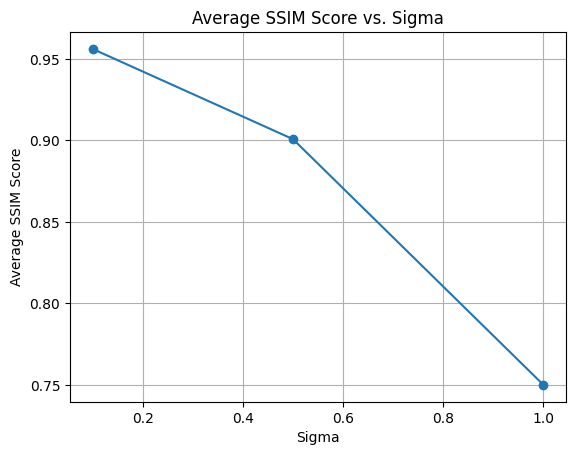

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
from torchvision import transforms
from torch.utils.data import DataLoader
from skimage.metrics import structural_similarity as ssim
import numpy as np
import matplotlib.pyplot as plt

# Load MNIST dataset
transform = transforms.Compose([
    transforms.ToTensor(),
])

train_dataset = torchvision.datasets.MNIST(root='./data', train=True, transform=transform, download=True)
test_dataset = torchvision.datasets.MNIST(root='./data', train=False, transform=transform, download=True)

train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=64, shuffle=False)

# Define Encoder
class Encoder(nn.Module):
    def __init__(self):
        super(Encoder, self).__init__()
        self.encoder = nn.Sequential(
            nn.Conv2d(1, 16, kernel_size=3, stride=1, padding=1),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2),
            nn.Conv2d(16, 8, kernel_size=3, stride=1, padding=1),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2)
        )

    def forward(self, x):
        x = self.encoder(x)
        return x

# Define Decoder
class Decoder(nn.Module):
    def __init__(self):
        super(Decoder, self).__init__()
        self.decoder = nn.Sequential(
            nn.ConvTranspose2d(8, 16, kernel_size=3, stride=2, padding=1, output_padding=1),
            nn.ReLU(inplace=True),
            nn.ConvTranspose2d(16, 1, kernel_size=3, stride=2, padding=1, output_padding=1),
            nn.Sigmoid()
        )

    def forward(self, x):
        x = self.decoder(x)
        return x

# Define the model
class Autoencoder(nn.Module):
    def __init__(self):
        super(Autoencoder, self).__init__()
        self.encoder = Encoder()
        self.decoder = Decoder()

    def forward(self, x):
        x = self.encoder(x)
        x = self.decoder(x)
        return x

# Initialize the model
model = Autoencoder()

# Define loss function and optimizer
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

# Training loop
def train_model(model, criterion, optimizer, train_loader, num_epochs=5):
    for epoch in range(num_epochs):
        running_loss = 0.0
        for images, _ in train_loader:
            optimizer.zero_grad()
            # Add Gaussian noise to images
            noise = torch.randn_like(images) * sigma
            noisy_images = images + noise
            outputs = model(noisy_images)
            loss = criterion(outputs, images)
            loss.backward()
            optimizer.step()
            running_loss += loss.item() * images.size(0)
        epoch_loss = running_loss / len(train_loader.dataset)
        print(f"Epoch [{epoch+1}/{num_epochs}], Loss: {epoch_loss:.4f}")

# Evaluate the model using SSIM
def evaluate_model(model, test_loader):
    ssim_scores = []
    with torch.no_grad():
        for images, _ in test_loader:
            reconstructed_images = model(images)
            for i in range(len(images)):
                original_image = images[i].squeeze().numpy()
                reconstructed_image = reconstructed_images[i].squeeze().numpy()
                score = ssim(original_image, reconstructed_image)
                ssim_scores.append(score)
    avg_ssim = np.mean(ssim_scores)
    return avg_ssim

# Train the model with different sigma values
sigma_values = [0.1, 0.5, 1.0]  # Define different sigma values
avg_ssim_scores = []

for sigma in sigma_values:
    model = Autoencoder()  # Reinitialize the model
    optimizer = optim.Adam(model.parameters(), lr=0.001)  # Reinitialize the optimizer
    train_model(model, criterion, optimizer, train_loader, num_epochs=5)
    avg_ssim = evaluate_model(model, test_loader)
    avg_ssim_scores.append(avg_ssim)

# Plot the average SSIM scores for different sigma values
plt.plot(sigma_values, avg_ssim_scores, marker='o')
plt.title('Average SSIM Score vs. Sigma')
plt.xlabel('Sigma')
plt.ylabel('Average SSIM Score')
plt.grid(True)
plt.show()


**Part 3**

Epoch [1/5], Loss: 0.0557
Epoch [2/5], Loss: 0.0283
Epoch [3/5], Loss: 0.0252
Epoch [4/5], Loss: 0.0237
Epoch [5/5], Loss: 0.0227
Epoch [1/5], Loss: 0.0393
Epoch [2/5], Loss: 0.0167
Epoch [3/5], Loss: 0.0145
Epoch [4/5], Loss: 0.0132
Epoch [5/5], Loss: 0.0124
Epoch [1/5], Loss: 0.0407
Epoch [2/5], Loss: 0.0127
Epoch [3/5], Loss: 0.0098
Epoch [4/5], Loss: 0.0087
Epoch [5/5], Loss: 0.0081


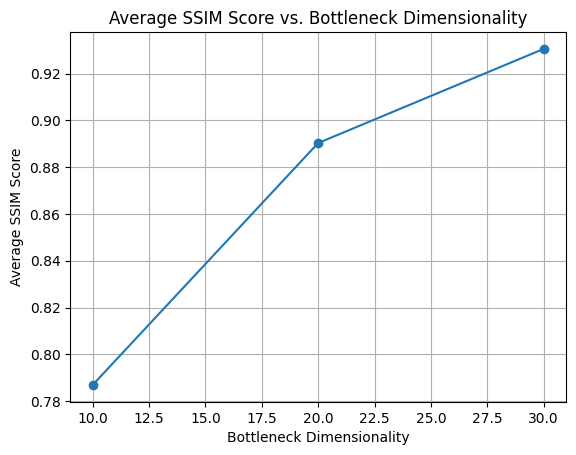

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
from torchvision import transforms
from torch.utils.data import DataLoader
from skimage.metrics import structural_similarity as ssim
import numpy as np
import matplotlib.pyplot as plt

# Load MNIST dataset
transform = transforms.Compose([
    transforms.ToTensor(),
])

train_dataset = torchvision.datasets.MNIST(root='./data', train=True, transform=transform, download=True)
test_dataset = torchvision.datasets.MNIST(root='./data', train=False, transform=transform, download=True)

train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=64, shuffle=False)

# Define Encoder
class Encoder(nn.Module):
    def __init__(self, bottleneck_dim):
        super(Encoder, self).__init__()
        self.encoder = nn.Sequential(
            nn.Conv2d(1, 16, kernel_size=3, stride=1, padding=1),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2),
            nn.Conv2d(16, 8, kernel_size=3, stride=1, padding=1),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2)
        )
        self.fc = nn.Linear(8 * 7 * 7, bottleneck_dim)

    def forward(self, x):
        x = self.encoder(x)
        x = x.view(x.size(0), -1)
        x = self.fc(x)
        return x

# Define Decoder
class Decoder(nn.Module):
    def __init__(self, bottleneck_dim):
        super(Decoder, self).__init__()
        self.fc = nn.Linear(bottleneck_dim, 8 * 7 * 7)
        self.decoder = nn.Sequential(
            nn.ConvTranspose2d(8, 16, kernel_size=3, stride=2, padding=1, output_padding=1),
            nn.ReLU(inplace=True),
            nn.ConvTranspose2d(16, 1, kernel_size=3, stride=2, padding=1, output_padding=1),
            nn.Sigmoid()
        )

    def forward(self, x):
        x = self.fc(x)
        x = x.view(x.size(0), 8, 7, 7)
        x = self.decoder(x)
        return x

# Define the model
class Autoencoder(nn.Module):
    def __init__(self, bottleneck_dim):
        super(Autoencoder, self).__init__()
        self.encoder = Encoder(bottleneck_dim)
        self.decoder = Decoder(bottleneck_dim)

    def forward(self, x):
        x = self.encoder(x)
        x = self.decoder(x)
        return x

# Initialize the model
bottleneck_dimensions = [10, 20, 30]  # Define different bottleneck dimensions
avg_ssim_scores = []

# Define loss function and optimizer
criterion = nn.MSELoss()

# Training loop
def train_model(model, criterion, optimizer, train_loader, num_epochs=5):
    for epoch in range(num_epochs):
        running_loss = 0.0
        for images, _ in train_loader:
            optimizer.zero_grad()
            outputs = model(images)
            loss = criterion(outputs, images)
            loss.backward()
            optimizer.step()
            running_loss += loss.item() * images.size(0)
        epoch_loss = running_loss / len(train_loader.dataset)
        print(f"Epoch [{epoch+1}/{num_epochs}], Loss: {epoch_loss:.4f}")

# Evaluate the model using SSIM
def evaluate_model(model, test_loader):
    ssim_scores = []
    with torch.no_grad():
        for images, _ in test_loader:
            reconstructed_images = model(images)
            for i in range(len(images)):
                original_image = images[i].squeeze().numpy()
                reconstructed_image = reconstructed_images[i].squeeze().numpy()
                score = ssim(original_image, reconstructed_image)
                ssim_scores.append(score)
    avg_ssim = np.mean(ssim_scores)
    return avg_ssim

for bottleneck_dim in bottleneck_dimensions:
    model = Autoencoder(bottleneck_dim)
    optimizer = optim.Adam(model.parameters(), lr=0.001)
    train_model(model, criterion, optimizer, train_loader, num_epochs=5)
    avg_ssim = evaluate_model(model, test_loader)
    avg_ssim_scores.append(avg_ssim)

# Plot the average SSIM scores for different bottleneck dimensions
plt.plot(bottleneck_dimensions, avg_ssim_scores, marker='o')
plt.title('Average SSIM Score vs. Bottleneck Dimensionality')
plt.xlabel('Bottleneck Dimensionality')
plt.ylabel('Average SSIM Score')
plt.grid(True)
plt.show()
